In [209]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import json, os, re, shutil, sys, time
from importlib import reload
import collections, itertools
import unittest
from IPython.display import display, HTML

# NLTK for NLP utils and corpora
import nltk

# Pandas NumPy and TensorFlow
import pandas as pd
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# Helper libraries
from utils import utils_proj, vocabulary

from sklearn.model_selection import train_test_split

import lstm; reload(lstm)
import matplotlib.pyplot as plt
% matplotlib inline

In [210]:
names = ['timestamp','date','query','handle','message']
df = pd.read_csv('../sentiment140.csv',encoding='Latin1',names=names)
df['sentiment'] = df.index
#Instead of positive being 4 make positive 1
df.loc[df['sentiment'] == 4,'sentiment']=1


In [211]:
df.head()

,timestamp,date,query,handle,message,sentiment
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0
0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0
0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0
0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0


In [317]:
#Just use 1000 rows while developing the code, full set takes too long
df1 = df#.sample(100000)
x_data = df1['message'].tolist()
y_data = df1['sentiment'].tolist()

#build the vocab
x_data = [i.split() for i in x_data]
flat_list = [item for sublist in x_data for item in sublist]
vocab = utils_proj.build_vocab(flat_list)


Vocabulary: 10,000 types


In [318]:
#Determine the length of the longest tweet
max_val=0
for i in x_data:
    if len(i) > max_val:
        max_val = len(i)
print(max_val)

64


In [319]:
max_time=70
#canonicalize sentences, convert to ids, pad to consistant length of 100
x_ids = []
for tweet in x_data:
    temp = utils_proj.preprocess_sentences([tweet],vocab)
    x_ids.append(
        np.pad(utils_proj.preprocess_sentences([tweet],vocab),(max_time-2-len(tweet),0),'constant').tolist()) 

In [320]:
#Split into 70% train, 15% dev, 15% test

def train_test_dev(x,y,train_pct=.8,test_pct=.1,random_state=1):
    #Split into train and test
    X_train, X_test, y_train, y_test = (
        train_test_split(x, y, test_size=round(1-train_pct,1), random_state=random_state))
    #split test into dev and test
    X_dev, X_test, y_dev, y_test = (
        train_test_split(X_test, y_test, test_size=test_pct/(1-train_pct), random_state=random_state))
    
    return np.asarray(X_train),np.asarray(X_dev),np.asarray(X_test),np.asarray(y_train),np.asarray(y_dev),np.asarray(y_test)


X_train,X_dev,X_test,y_train,y_dev,y_test = train_test_dev(x_ids,y_data,.7,.15)

In [321]:
def run_epoch(lm, session, batch_iterator,
              train=False, verbose=False,
              tick_s=10, learning_rate=None):
    assert(learning_rate is not None)
    start_time = time.time()
    tick_time = start_time  # for showing status
    total_cost = 0.0  # total cost, summed over all words
    total_batches = 0
    total_tweets = 0
    
    if train:
        train_op = lm.optimizer_
        use_dropout = True
        loss = lm.train_loss_
    else:
        train_op = tf.no_op()
        use_dropout = False  # no dropout at test time
        loss = lm.train_loss_  # true loss, if train_loss is an approximation
        
    val_acc = []
    y_true = []
    y_pred = []
    for i, (w, y) in enumerate(batch_iterator):
        # At first batch in epoch, get a clean intitial state.
        
        y_true.append(y)
        if i == 0:
            h = session.run(lm.initial_h_, {lm.input_w_: w})
        feed_dict = {
            lm.input_w_: w,
            lm.target_y_: y,
            lm.initial_h_: h,
            lm.learning_rate_: learning_rate,

        }
        ops = [loss, lm.final_h_, train_op,lm.accuracy_,lm.predictions_]        
        # session.run(...) the ops with the feed_dict constructed above.
        # Ensure "cost" becomes the value of "loss".
        # Hint: see "ops" for other variables that need updating in this loop.
        cost,h,_,batch_acc,preds = session.run(ops,feed_dict=feed_dict)
        
        y_pred.append(preds)
        val_acc.append(batch_acc)
        total_cost += cost
        total_batches = i + 1
        total_tweets += w.shape[0]  

        ##
        # Print average loss-so-far for epoch
        # If using train_loss_, this may be an underestimate.
        if verbose and (time.time() - tick_time >= tick_s):
            avg_cost = total_cost / total_batches
            avg_tps = total_tweets / (time.time() - start_time)
            print("[batch {:d}]: seen {:d} tweets at {:.1f} tps, cost = {:.3f}".format(
                i, total_tweets, avg_tps, avg_cost))
            tick_time = time.time()  # reset time ticker
    if train:
        return total_cost / total_batches,val_acc
    else:
        return total_cost / total_batches, val_acc,y_true,y_pred

In [322]:
def score_dataset(lm, session,ids,labels, name="Data"):
    # For scoring, we can use larger batches to speed things up.
    bi = utils_proj.rnnlm_batch_generator(ids, 100, 100,labels)
    cost,logits = run_epoch(lm, session, bi, 
                     learning_rate=0.0, train=False, 
                     verbose=False, tick_s=3600)
    print("{:s}: avg. loss: {:.03f}  (perplexity: {:.02f})".format(name, cost, np.exp(cost)))
    return cost

In [323]:
# Training parameters
max_time = max_time
batch_size = 1000
learning_rate = 0.01
num_epochs = 5

# Model parameters
model_params = dict(V=vocab.size, 
                    H=50, 
                    softmax_ns=200,
                    num_layers=2,
                    num_classes=1)

#TF_GRAPHDIR = "/tmp/w266/a3_graph"
summary_writer = tf.summary.FileWriter(TF_GRAPHDIR, lm.graph)
TF_SAVEDIR = "/tmp/w266/a3_model"

checkpoint_filename = os.path.join(TF_SAVEDIR, "rnnlm")
trained_filename = os.path.join(TF_SAVEDIR, "rnnlm_trained")

In [324]:
# Will print status every this many seconds
reload(lstm)
reload(utils_proj)
print_interval = 5

lm = lstm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

# Explicitly add global initializer and variable saver to LM graph
with lm.graph.as_default():
    initializer = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# Clear old log directory
shutil.rmtree(TF_SAVEDIR, ignore_errors=True)
if not os.path.isdir(TF_SAVEDIR):
    os.makedirs(TF_SAVEDIR)

with tf.Session(graph=lm.graph) as session:
    # Seed RNG for repeatability
    tf.set_random_seed(42)

    session.run(initializer)
    
    
    for epoch in range(1,num_epochs+1):
        t0_epoch = time.time()
        bi = utils_proj.rnnlm_batch_generator(X_train, batch_size, max_time,y_train)

        cost,val_acc = run_epoch(lm, session, bi,True,
                  True,1.0,learning_rate)
        
        #### END(YOUR CODE) ####
        print("[epoch {:d}] Completed in {:s}".format(epoch, utils_proj.pretty_timedelta(since=t0_epoch)))
    
        # Save a checkpointls 
        saver.save(session, checkpoint_filename, global_step=epoch)
    
    saver.save(session, trained_filename)

[batch 0]: seen 1000 tweets at 935.8 tps, cost = 0.250
[batch 2]: seen 3000 tweets at 1303.6 tps, cost = 0.249
[batch 4]: seen 5000 tweets at 1447.2 tps, cost = 0.246
[batch 6]: seen 7000 tweets at 1515.8 tps, cost = 0.245
[batch 8]: seen 9000 tweets at 1562.5 tps, cost = 0.243
[batch 10]: seen 11000 tweets at 1589.0 tps, cost = 0.241
[batch 12]: seen 13000 tweets at 1612.4 tps, cost = 0.238
[batch 14]: seen 15000 tweets at 1627.7 tps, cost = 0.235
[batch 16]: seen 17000 tweets at 1639.1 tps, cost = 0.232
[batch 18]: seen 19000 tweets at 1647.4 tps, cost = 0.229
[batch 20]: seen 21000 tweets at 1655.7 tps, cost = 0.227
[batch 22]: seen 23000 tweets at 1663.4 tps, cost = 0.224
[batch 24]: seen 25000 tweets at 1668.1 tps, cost = 0.223
[batch 26]: seen 27000 tweets at 1672.7 tps, cost = 0.220
[batch 28]: seen 29000 tweets at 1678.3 tps, cost = 0.219
[batch 30]: seen 31000 tweets at 1683.0 tps, cost = 0.217
[batch 32]: seen 33000 tweets at 1686.8 tps, cost = 0.215
[batch 34]: seen 35000 tw

[batch 278]: seen 279000 tweets at 1736.0 tps, cost = 0.159
[batch 280]: seen 281000 tweets at 1736.2 tps, cost = 0.159
[batch 282]: seen 283000 tweets at 1736.3 tps, cost = 0.159
[batch 284]: seen 285000 tweets at 1736.4 tps, cost = 0.159
[batch 286]: seen 287000 tweets at 1736.6 tps, cost = 0.159
[batch 288]: seen 289000 tweets at 1736.7 tps, cost = 0.159
[batch 290]: seen 291000 tweets at 1736.7 tps, cost = 0.158
[batch 292]: seen 293000 tweets at 1736.8 tps, cost = 0.158
[batch 294]: seen 295000 tweets at 1737.0 tps, cost = 0.158
[batch 296]: seen 297000 tweets at 1737.0 tps, cost = 0.158
[batch 298]: seen 299000 tweets at 1737.1 tps, cost = 0.158
[batch 300]: seen 301000 tweets at 1737.3 tps, cost = 0.158
[batch 302]: seen 303000 tweets at 1737.3 tps, cost = 0.158
[batch 304]: seen 305000 tweets at 1737.2 tps, cost = 0.158
[batch 306]: seen 307000 tweets at 1737.1 tps, cost = 0.157
[batch 308]: seen 309000 tweets at 1737.0 tps, cost = 0.157
[batch 310]: seen 311000 tweets at 1737.

[batch 552]: seen 553000 tweets at 1735.1 tps, cost = 0.148
[batch 554]: seen 555000 tweets at 1735.1 tps, cost = 0.148
[batch 556]: seen 557000 tweets at 1735.1 tps, cost = 0.148
[batch 558]: seen 559000 tweets at 1735.2 tps, cost = 0.148
[batch 560]: seen 561000 tweets at 1735.3 tps, cost = 0.148
[batch 562]: seen 563000 tweets at 1735.3 tps, cost = 0.148
[batch 564]: seen 565000 tweets at 1735.3 tps, cost = 0.148
[batch 566]: seen 567000 tweets at 1735.4 tps, cost = 0.148
[batch 568]: seen 569000 tweets at 1735.5 tps, cost = 0.148
[batch 570]: seen 571000 tweets at 1735.5 tps, cost = 0.148
[batch 572]: seen 573000 tweets at 1735.5 tps, cost = 0.148
[batch 574]: seen 575000 tweets at 1735.6 tps, cost = 0.148
[batch 576]: seen 577000 tweets at 1735.7 tps, cost = 0.148
[batch 578]: seen 579000 tweets at 1735.8 tps, cost = 0.148
[batch 580]: seen 581000 tweets at 1735.8 tps, cost = 0.148
[batch 582]: seen 583000 tweets at 1735.9 tps, cost = 0.148
[batch 584]: seen 585000 tweets at 1735.

[batch 826]: seen 827000 tweets at 1739.6 tps, cost = 0.144
[batch 828]: seen 829000 tweets at 1739.5 tps, cost = 0.143
[batch 830]: seen 831000 tweets at 1739.5 tps, cost = 0.143
[batch 832]: seen 833000 tweets at 1739.6 tps, cost = 0.143
[batch 834]: seen 835000 tweets at 1739.6 tps, cost = 0.143
[batch 836]: seen 837000 tweets at 1739.5 tps, cost = 0.143
[batch 838]: seen 839000 tweets at 1739.5 tps, cost = 0.143
[batch 840]: seen 841000 tweets at 1739.5 tps, cost = 0.143
[batch 842]: seen 843000 tweets at 1739.5 tps, cost = 0.143
[batch 844]: seen 845000 tweets at 1739.5 tps, cost = 0.143
[batch 846]: seen 847000 tweets at 1739.4 tps, cost = 0.143
[batch 848]: seen 849000 tweets at 1739.4 tps, cost = 0.143
[batch 850]: seen 851000 tweets at 1739.4 tps, cost = 0.143
[batch 852]: seen 853000 tweets at 1739.3 tps, cost = 0.143
[batch 854]: seen 855000 tweets at 1739.3 tps, cost = 0.143
[batch 856]: seen 857000 tweets at 1739.3 tps, cost = 0.143
[batch 858]: seen 859000 tweets at 1739.

[batch 1096]: seen 1097000 tweets at 1737.4 tps, cost = 0.140
[batch 1098]: seen 1099000 tweets at 1737.4 tps, cost = 0.140
[batch 1100]: seen 1101000 tweets at 1737.4 tps, cost = 0.140
[batch 1102]: seen 1103000 tweets at 1737.4 tps, cost = 0.140
[batch 1104]: seen 1105000 tweets at 1737.4 tps, cost = 0.140
[batch 1106]: seen 1107000 tweets at 1737.4 tps, cost = 0.140
[batch 1108]: seen 1109000 tweets at 1737.5 tps, cost = 0.140
[batch 1110]: seen 1111000 tweets at 1737.5 tps, cost = 0.140
[batch 1112]: seen 1113000 tweets at 1737.5 tps, cost = 0.140
[batch 1114]: seen 1115000 tweets at 1737.5 tps, cost = 0.140
[batch 1116]: seen 1117000 tweets at 1737.5 tps, cost = 0.140
[batch 1118]: seen 1119000 tweets at 1737.6 tps, cost = 0.140
[epoch 1] Completed in 0:10:44
[batch 1]: seen 2000 tweets at 1754.6 tps, cost = 0.126
[batch 3]: seen 4000 tweets at 1748.3 tps, cost = 0.128
[batch 5]: seen 6000 tweets at 1747.2 tps, cost = 0.129
[batch 7]: seen 8000 tweets at 1749.2 tps, cost = 0.130
[

[batch 253]: seen 254000 tweets at 1729.7 tps, cost = 0.127
[batch 255]: seen 256000 tweets at 1729.4 tps, cost = 0.127
[batch 257]: seen 258000 tweets at 1729.4 tps, cost = 0.127
[batch 259]: seen 260000 tweets at 1729.3 tps, cost = 0.127
[batch 261]: seen 262000 tweets at 1729.1 tps, cost = 0.127
[batch 263]: seen 264000 tweets at 1728.8 tps, cost = 0.127
[batch 265]: seen 266000 tweets at 1728.7 tps, cost = 0.127
[batch 267]: seen 268000 tweets at 1728.5 tps, cost = 0.127
[batch 269]: seen 270000 tweets at 1728.5 tps, cost = 0.127
[batch 271]: seen 272000 tweets at 1728.6 tps, cost = 0.127
[batch 273]: seen 274000 tweets at 1728.6 tps, cost = 0.127
[batch 275]: seen 276000 tweets at 1728.5 tps, cost = 0.127
[batch 277]: seen 278000 tweets at 1728.5 tps, cost = 0.127
[batch 279]: seen 280000 tweets at 1728.3 tps, cost = 0.127
[batch 281]: seen 282000 tweets at 1728.4 tps, cost = 0.127
[batch 283]: seen 284000 tweets at 1728.5 tps, cost = 0.127
[batch 285]: seen 286000 tweets at 1728.

[batch 527]: seen 528000 tweets at 1727.2 tps, cost = 0.126
[batch 529]: seen 530000 tweets at 1727.2 tps, cost = 0.126
[batch 531]: seen 532000 tweets at 1727.2 tps, cost = 0.126
[batch 533]: seen 534000 tweets at 1727.3 tps, cost = 0.126
[batch 535]: seen 536000 tweets at 1727.3 tps, cost = 0.126
[batch 537]: seen 538000 tweets at 1727.4 tps, cost = 0.126
[batch 539]: seen 540000 tweets at 1727.4 tps, cost = 0.126
[batch 541]: seen 542000 tweets at 1727.5 tps, cost = 0.126
[batch 543]: seen 544000 tweets at 1727.6 tps, cost = 0.126
[batch 545]: seen 546000 tweets at 1727.6 tps, cost = 0.126
[batch 547]: seen 548000 tweets at 1727.7 tps, cost = 0.126
[batch 549]: seen 550000 tweets at 1727.8 tps, cost = 0.126
[batch 551]: seen 552000 tweets at 1727.9 tps, cost = 0.126
[batch 553]: seen 554000 tweets at 1728.0 tps, cost = 0.126
[batch 555]: seen 556000 tweets at 1728.1 tps, cost = 0.126
[batch 557]: seen 558000 tweets at 1727.9 tps, cost = 0.126
[batch 559]: seen 560000 tweets at 1727.

[batch 801]: seen 802000 tweets at 1726.2 tps, cost = 0.125
[batch 803]: seen 804000 tweets at 1726.2 tps, cost = 0.125
[batch 805]: seen 806000 tweets at 1726.1 tps, cost = 0.125
[batch 807]: seen 808000 tweets at 1726.1 tps, cost = 0.125
[batch 809]: seen 810000 tweets at 1726.1 tps, cost = 0.125
[batch 811]: seen 812000 tweets at 1726.1 tps, cost = 0.125
[batch 813]: seen 814000 tweets at 1726.1 tps, cost = 0.125
[batch 815]: seen 816000 tweets at 1726.1 tps, cost = 0.125
[batch 817]: seen 818000 tweets at 1726.0 tps, cost = 0.125
[batch 819]: seen 820000 tweets at 1726.0 tps, cost = 0.125
[batch 821]: seen 822000 tweets at 1726.0 tps, cost = 0.125
[batch 823]: seen 824000 tweets at 1726.0 tps, cost = 0.125
[batch 825]: seen 826000 tweets at 1726.0 tps, cost = 0.125
[batch 827]: seen 828000 tweets at 1726.0 tps, cost = 0.125
[batch 829]: seen 830000 tweets at 1726.0 tps, cost = 0.125
[batch 831]: seen 832000 tweets at 1726.0 tps, cost = 0.125
[batch 833]: seen 834000 tweets at 1726.

[batch 1073]: seen 1074000 tweets at 1722.3 tps, cost = 0.124
[batch 1075]: seen 1076000 tweets at 1722.3 tps, cost = 0.124
[batch 1077]: seen 1078000 tweets at 1722.3 tps, cost = 0.124
[batch 1079]: seen 1080000 tweets at 1722.3 tps, cost = 0.124
[batch 1081]: seen 1082000 tweets at 1722.3 tps, cost = 0.124
[batch 1083]: seen 1084000 tweets at 1722.3 tps, cost = 0.124
[batch 1085]: seen 1086000 tweets at 1722.3 tps, cost = 0.124
[batch 1087]: seen 1088000 tweets at 1722.3 tps, cost = 0.124
[batch 1089]: seen 1090000 tweets at 1722.4 tps, cost = 0.124
[batch 1091]: seen 1092000 tweets at 1722.4 tps, cost = 0.124
[batch 1093]: seen 1094000 tweets at 1722.4 tps, cost = 0.124
[batch 1095]: seen 1096000 tweets at 1722.5 tps, cost = 0.124
[batch 1097]: seen 1098000 tweets at 1722.4 tps, cost = 0.124
[batch 1099]: seen 1100000 tweets at 1722.3 tps, cost = 0.124
[batch 1101]: seen 1102000 tweets at 1722.2 tps, cost = 0.124
[batch 1103]: seen 1104000 tweets at 1722.0 tps, cost = 0.124
[batch 1

[batch 229]: seen 230000 tweets at 1706.8 tps, cost = 0.120
[batch 231]: seen 232000 tweets at 1706.6 tps, cost = 0.120
[batch 233]: seen 234000 tweets at 1706.7 tps, cost = 0.120
[batch 235]: seen 236000 tweets at 1706.9 tps, cost = 0.120
[batch 237]: seen 238000 tweets at 1707.0 tps, cost = 0.120
[batch 239]: seen 240000 tweets at 1706.9 tps, cost = 0.120
[batch 241]: seen 242000 tweets at 1707.1 tps, cost = 0.120
[batch 243]: seen 244000 tweets at 1707.0 tps, cost = 0.120
[batch 245]: seen 246000 tweets at 1707.1 tps, cost = 0.120
[batch 247]: seen 248000 tweets at 1707.3 tps, cost = 0.120
[batch 249]: seen 250000 tweets at 1707.3 tps, cost = 0.120
[batch 251]: seen 252000 tweets at 1707.4 tps, cost = 0.120
[batch 253]: seen 254000 tweets at 1707.3 tps, cost = 0.120
[batch 255]: seen 256000 tweets at 1707.3 tps, cost = 0.120
[batch 257]: seen 258000 tweets at 1707.2 tps, cost = 0.120
[batch 259]: seen 260000 tweets at 1707.1 tps, cost = 0.120
[batch 261]: seen 262000 tweets at 1707.

[batch 503]: seen 504000 tweets at 1698.3 tps, cost = 0.119
[batch 505]: seen 506000 tweets at 1698.4 tps, cost = 0.119
[batch 507]: seen 508000 tweets at 1698.5 tps, cost = 0.119
[batch 509]: seen 510000 tweets at 1698.5 tps, cost = 0.119
[batch 511]: seen 512000 tweets at 1698.6 tps, cost = 0.119
[batch 513]: seen 514000 tweets at 1698.6 tps, cost = 0.119
[batch 515]: seen 516000 tweets at 1698.7 tps, cost = 0.119
[batch 517]: seen 518000 tweets at 1698.7 tps, cost = 0.119
[batch 519]: seen 520000 tweets at 1698.8 tps, cost = 0.119
[batch 521]: seen 522000 tweets at 1698.9 tps, cost = 0.119
[batch 523]: seen 524000 tweets at 1698.9 tps, cost = 0.119
[batch 525]: seen 526000 tweets at 1699.0 tps, cost = 0.119
[batch 527]: seen 528000 tweets at 1699.0 tps, cost = 0.119
[batch 529]: seen 530000 tweets at 1699.0 tps, cost = 0.119
[batch 531]: seen 532000 tweets at 1699.0 tps, cost = 0.119
[batch 533]: seen 534000 tweets at 1699.1 tps, cost = 0.119
[batch 535]: seen 536000 tweets at 1699.

[batch 777]: seen 778000 tweets at 1701.5 tps, cost = 0.119
[batch 779]: seen 780000 tweets at 1701.5 tps, cost = 0.119
[batch 781]: seen 782000 tweets at 1701.6 tps, cost = 0.118
[batch 783]: seen 784000 tweets at 1701.7 tps, cost = 0.118
[batch 785]: seen 786000 tweets at 1701.7 tps, cost = 0.118
[batch 787]: seen 788000 tweets at 1701.7 tps, cost = 0.118
[batch 789]: seen 790000 tweets at 1701.8 tps, cost = 0.118
[batch 791]: seen 792000 tweets at 1701.9 tps, cost = 0.118
[batch 793]: seen 794000 tweets at 1702.0 tps, cost = 0.118
[batch 795]: seen 796000 tweets at 1702.0 tps, cost = 0.118
[batch 797]: seen 798000 tweets at 1702.1 tps, cost = 0.118
[batch 799]: seen 800000 tweets at 1702.1 tps, cost = 0.118
[batch 801]: seen 802000 tweets at 1702.0 tps, cost = 0.118
[batch 803]: seen 804000 tweets at 1702.1 tps, cost = 0.118
[batch 805]: seen 806000 tweets at 1702.2 tps, cost = 0.118
[batch 807]: seen 808000 tweets at 1702.2 tps, cost = 0.118
[batch 809]: seen 810000 tweets at 1702.

[batch 1049]: seen 1050000 tweets at 1703.7 tps, cost = 0.118
[batch 1051]: seen 1052000 tweets at 1703.7 tps, cost = 0.118
[batch 1053]: seen 1054000 tweets at 1703.8 tps, cost = 0.118
[batch 1055]: seen 1056000 tweets at 1703.8 tps, cost = 0.118
[batch 1057]: seen 1058000 tweets at 1703.8 tps, cost = 0.118
[batch 1059]: seen 1060000 tweets at 1703.9 tps, cost = 0.118
[batch 1061]: seen 1062000 tweets at 1703.9 tps, cost = 0.118
[batch 1063]: seen 1064000 tweets at 1703.9 tps, cost = 0.118
[batch 1065]: seen 1066000 tweets at 1703.9 tps, cost = 0.118
[batch 1067]: seen 1068000 tweets at 1704.0 tps, cost = 0.118
[batch 1069]: seen 1070000 tweets at 1704.0 tps, cost = 0.118
[batch 1071]: seen 1072000 tweets at 1704.1 tps, cost = 0.118
[batch 1073]: seen 1074000 tweets at 1704.1 tps, cost = 0.118
[batch 1075]: seen 1076000 tweets at 1704.2 tps, cost = 0.118
[batch 1077]: seen 1078000 tweets at 1704.2 tps, cost = 0.118
[batch 1079]: seen 1080000 tweets at 1704.3 tps, cost = 0.118
[batch 1

[batch 203]: seen 204000 tweets at 1733.5 tps, cost = 0.116
[batch 205]: seen 206000 tweets at 1733.6 tps, cost = 0.116
[batch 207]: seen 208000 tweets at 1733.5 tps, cost = 0.116
[batch 209]: seen 210000 tweets at 1733.2 tps, cost = 0.116
[batch 211]: seen 212000 tweets at 1733.2 tps, cost = 0.116
[batch 213]: seen 214000 tweets at 1732.9 tps, cost = 0.116
[batch 215]: seen 216000 tweets at 1732.7 tps, cost = 0.116
[batch 217]: seen 218000 tweets at 1732.9 tps, cost = 0.116
[batch 219]: seen 220000 tweets at 1733.0 tps, cost = 0.116
[batch 221]: seen 222000 tweets at 1733.1 tps, cost = 0.115
[batch 223]: seen 224000 tweets at 1733.1 tps, cost = 0.115
[batch 225]: seen 226000 tweets at 1733.2 tps, cost = 0.115
[batch 227]: seen 228000 tweets at 1733.2 tps, cost = 0.115
[batch 229]: seen 230000 tweets at 1733.3 tps, cost = 0.115
[batch 231]: seen 232000 tweets at 1733.4 tps, cost = 0.115
[batch 233]: seen 234000 tweets at 1733.6 tps, cost = 0.115
[batch 235]: seen 236000 tweets at 1733.

[batch 477]: seen 478000 tweets at 1732.7 tps, cost = 0.115
[batch 479]: seen 480000 tweets at 1732.6 tps, cost = 0.115
[batch 481]: seen 482000 tweets at 1732.7 tps, cost = 0.115
[batch 483]: seen 484000 tweets at 1732.7 tps, cost = 0.115
[batch 485]: seen 486000 tweets at 1732.8 tps, cost = 0.115
[batch 487]: seen 488000 tweets at 1732.8 tps, cost = 0.115
[batch 489]: seen 490000 tweets at 1732.8 tps, cost = 0.115
[batch 491]: seen 492000 tweets at 1732.9 tps, cost = 0.115
[batch 493]: seen 494000 tweets at 1733.0 tps, cost = 0.115
[batch 495]: seen 496000 tweets at 1733.1 tps, cost = 0.115
[batch 497]: seen 498000 tweets at 1733.1 tps, cost = 0.115
[batch 499]: seen 500000 tweets at 1733.2 tps, cost = 0.115
[batch 501]: seen 502000 tweets at 1733.4 tps, cost = 0.115
[batch 503]: seen 504000 tweets at 1733.6 tps, cost = 0.115
[batch 505]: seen 506000 tweets at 1733.7 tps, cost = 0.115
[batch 507]: seen 508000 tweets at 1733.8 tps, cost = 0.115
[batch 509]: seen 510000 tweets at 1733.

[batch 751]: seen 752000 tweets at 1738.5 tps, cost = 0.114
[batch 753]: seen 754000 tweets at 1738.5 tps, cost = 0.114
[batch 755]: seen 756000 tweets at 1738.5 tps, cost = 0.114
[batch 757]: seen 758000 tweets at 1738.6 tps, cost = 0.114
[batch 759]: seen 760000 tweets at 1738.6 tps, cost = 0.114
[batch 761]: seen 762000 tweets at 1738.7 tps, cost = 0.114
[batch 763]: seen 764000 tweets at 1738.7 tps, cost = 0.114
[batch 765]: seen 766000 tweets at 1738.6 tps, cost = 0.114
[batch 767]: seen 768000 tweets at 1738.7 tps, cost = 0.114
[batch 769]: seen 770000 tweets at 1738.7 tps, cost = 0.114
[batch 771]: seen 772000 tweets at 1738.8 tps, cost = 0.114
[batch 773]: seen 774000 tweets at 1738.8 tps, cost = 0.114
[batch 775]: seen 776000 tweets at 1738.9 tps, cost = 0.114
[batch 777]: seen 778000 tweets at 1739.0 tps, cost = 0.114
[batch 779]: seen 780000 tweets at 1739.0 tps, cost = 0.114
[batch 781]: seen 782000 tweets at 1739.1 tps, cost = 0.114
[batch 783]: seen 784000 tweets at 1739.

[batch 1025]: seen 1026000 tweets at 1737.4 tps, cost = 0.114
[batch 1027]: seen 1028000 tweets at 1737.4 tps, cost = 0.114
[batch 1029]: seen 1030000 tweets at 1737.3 tps, cost = 0.114
[batch 1031]: seen 1032000 tweets at 1737.3 tps, cost = 0.114
[batch 1033]: seen 1034000 tweets at 1737.3 tps, cost = 0.114
[batch 1035]: seen 1036000 tweets at 1737.3 tps, cost = 0.114
[batch 1037]: seen 1038000 tweets at 1737.3 tps, cost = 0.114
[batch 1039]: seen 1040000 tweets at 1737.3 tps, cost = 0.114
[batch 1041]: seen 1042000 tweets at 1737.3 tps, cost = 0.114
[batch 1043]: seen 1044000 tweets at 1737.3 tps, cost = 0.114
[batch 1045]: seen 1046000 tweets at 1737.4 tps, cost = 0.114
[batch 1047]: seen 1048000 tweets at 1737.4 tps, cost = 0.114
[batch 1049]: seen 1050000 tweets at 1737.4 tps, cost = 0.114
[batch 1051]: seen 1052000 tweets at 1737.4 tps, cost = 0.114
[batch 1053]: seen 1054000 tweets at 1737.3 tps, cost = 0.114
[batch 1055]: seen 1056000 tweets at 1737.3 tps, cost = 0.114
[batch 1

[batch 179]: seen 180000 tweets at 1726.3 tps, cost = 0.113
[batch 181]: seen 182000 tweets at 1726.4 tps, cost = 0.113
[batch 183]: seen 184000 tweets at 1726.3 tps, cost = 0.113
[batch 185]: seen 186000 tweets at 1726.3 tps, cost = 0.113
[batch 187]: seen 188000 tweets at 1726.1 tps, cost = 0.113
[batch 189]: seen 190000 tweets at 1726.0 tps, cost = 0.113
[batch 191]: seen 192000 tweets at 1725.8 tps, cost = 0.113
[batch 193]: seen 194000 tweets at 1725.7 tps, cost = 0.112
[batch 195]: seen 196000 tweets at 1725.7 tps, cost = 0.113
[batch 197]: seen 198000 tweets at 1725.3 tps, cost = 0.113
[batch 199]: seen 200000 tweets at 1725.3 tps, cost = 0.113
[batch 201]: seen 202000 tweets at 1725.4 tps, cost = 0.112
[batch 203]: seen 204000 tweets at 1725.6 tps, cost = 0.112
[batch 205]: seen 206000 tweets at 1725.5 tps, cost = 0.112
[batch 207]: seen 208000 tweets at 1725.6 tps, cost = 0.112
[batch 209]: seen 210000 tweets at 1725.7 tps, cost = 0.112
[batch 211]: seen 212000 tweets at 1725.

[batch 453]: seen 454000 tweets at 1720.6 tps, cost = 0.112
[batch 455]: seen 456000 tweets at 1720.6 tps, cost = 0.112
[batch 457]: seen 458000 tweets at 1720.7 tps, cost = 0.112
[batch 459]: seen 460000 tweets at 1720.8 tps, cost = 0.112
[batch 461]: seen 462000 tweets at 1720.8 tps, cost = 0.112
[batch 463]: seen 464000 tweets at 1720.9 tps, cost = 0.112
[batch 465]: seen 466000 tweets at 1720.9 tps, cost = 0.112
[batch 467]: seen 468000 tweets at 1720.9 tps, cost = 0.112
[batch 469]: seen 470000 tweets at 1720.9 tps, cost = 0.112
[batch 471]: seen 472000 tweets at 1720.9 tps, cost = 0.112
[batch 473]: seen 474000 tweets at 1721.0 tps, cost = 0.112
[batch 475]: seen 476000 tweets at 1721.0 tps, cost = 0.112
[batch 477]: seen 478000 tweets at 1721.1 tps, cost = 0.112
[batch 479]: seen 480000 tweets at 1721.2 tps, cost = 0.112
[batch 481]: seen 482000 tweets at 1721.4 tps, cost = 0.112
[batch 483]: seen 484000 tweets at 1721.5 tps, cost = 0.112
[batch 485]: seen 486000 tweets at 1721.

[batch 727]: seen 728000 tweets at 1728.4 tps, cost = 0.112
[batch 729]: seen 730000 tweets at 1728.4 tps, cost = 0.112
[batch 731]: seen 732000 tweets at 1728.5 tps, cost = 0.112
[batch 733]: seen 734000 tweets at 1728.5 tps, cost = 0.112
[batch 735]: seen 736000 tweets at 1728.6 tps, cost = 0.112
[batch 737]: seen 738000 tweets at 1728.6 tps, cost = 0.112
[batch 739]: seen 740000 tweets at 1728.7 tps, cost = 0.112
[batch 741]: seen 742000 tweets at 1728.7 tps, cost = 0.112
[batch 743]: seen 744000 tweets at 1728.8 tps, cost = 0.112
[batch 745]: seen 746000 tweets at 1728.8 tps, cost = 0.112
[batch 747]: seen 748000 tweets at 1728.8 tps, cost = 0.112
[batch 749]: seen 750000 tweets at 1728.8 tps, cost = 0.112
[batch 751]: seen 752000 tweets at 1728.9 tps, cost = 0.112
[batch 753]: seen 754000 tweets at 1729.0 tps, cost = 0.112
[batch 755]: seen 756000 tweets at 1729.0 tps, cost = 0.112
[batch 757]: seen 758000 tweets at 1729.0 tps, cost = 0.112
[batch 759]: seen 760000 tweets at 1729.

[batch 1001]: seen 1002000 tweets at 1729.8 tps, cost = 0.111
[batch 1003]: seen 1004000 tweets at 1729.9 tps, cost = 0.111
[batch 1005]: seen 1006000 tweets at 1730.0 tps, cost = 0.111
[batch 1007]: seen 1008000 tweets at 1730.1 tps, cost = 0.111
[batch 1009]: seen 1010000 tweets at 1730.1 tps, cost = 0.111
[batch 1011]: seen 1012000 tweets at 1730.1 tps, cost = 0.111
[batch 1013]: seen 1014000 tweets at 1730.2 tps, cost = 0.111
[batch 1015]: seen 1016000 tweets at 1730.2 tps, cost = 0.111
[batch 1017]: seen 1018000 tweets at 1730.2 tps, cost = 0.111
[batch 1019]: seen 1020000 tweets at 1730.3 tps, cost = 0.111
[batch 1021]: seen 1022000 tweets at 1730.3 tps, cost = 0.111
[batch 1023]: seen 1024000 tweets at 1730.3 tps, cost = 0.111
[batch 1025]: seen 1026000 tweets at 1730.2 tps, cost = 0.111
[batch 1027]: seen 1028000 tweets at 1730.3 tps, cost = 0.111
[batch 1029]: seen 1030000 tweets at 1730.4 tps, cost = 0.111
[batch 1031]: seen 1032000 tweets at 1730.4 tps, cost = 0.111
[batch 1

In [331]:
# Testingg parameters
max_time = max_time
batch_size = 100
learning_rate = 0.00
num_epochs = 1
reload(lstm)
# Will print status every this many seconds
print_interval = 5

lm = lstm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

with lm.graph.as_default():
    saver = tf.train.Saver()

y_pred=[]
y_true=[]
val_acc=[]
num_equals=[]
    
with tf.Session(graph=lm.graph) as session:
    saver.restore(session, trained_filename)
    
    for epoch in range(1,num_epochs+1):
        t0_epoch = time.time()
        bi = utils_proj.rnnlm_batch_generator(X_test, batch_size, max_time,y_test)
        print("[epoch {:d}] Starting epoch {:d}".format(epoch, epoch))
        # Run a training epoch.
        
        
        for i, (w, y) in enumerate(bi):
            # At first batch in epoch, get a clean intitial state.

            y_true.append(y)
            if i == 0:
                h = session.run(lm.initial_h_, {lm.input_w_: w})
            feed_dict = {
                lm.input_w_: w,
                lm.target_y_: y,
                lm.initial_h_: h,


            }
            ops = [lm.final_h_, lm.accuracy_,lm.predictions_,lm.num_equal_]        
            # session.run(...) the ops with the feed_dict constructed above.
            # Ensure "cost" becomes the value of "loss".
            # Hint: see "ops" for other variables that need updating in this loop.
            h,batch_acc,preds,num_equal = session.run(ops,feed_dict=feed_dict)

            val_acc.append(batch_acc)
            num_equals.append(num_equal)

    #        cost,val_acc,true,pred = run_epoch(lm, session, bi,False,
    #                  True,1.0,learning_rate)

            
            y_pred.append(preds)

            print("[epoch {:d}] Completed in {:s}".format(epoch, utils_proj.pretty_timedelta(since=t0_epoch)))
   
        print(batch_acc)


INFO:tensorflow:Restoring parameters from /tmp/w266/a3_model/rnnlm_trained
[epoch 1] Starting epoch 1
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:01

[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1] Completed in 0:00:09
[epoch 1

[epoch 1] Completed in 0:00:16
[epoch 1] Completed in 0:00:16
[epoch 1] Completed in 0:00:16
[epoch 1] Completed in 0:00:16
[epoch 1] Completed in 0:00:16
[epoch 1] Completed in 0:00:16
[epoch 1] Completed in 0:00:16
[epoch 1] Completed in 0:00:16
[epoch 1] Completed in 0:00:16
[epoch 1] Completed in 0:00:16
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1] Completed in 0:00:17
[epoch 1

[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:25
[epoch 1] Completed in 0:00:26
[epoch 1] Completed in 0:00:26
[epoch 1] Completed in 0:00:26
[epoch 1] Completed in 0:00:26
[epoch 1] Completed in 0:00:26
[epoch 1] Completed in 0:00:26
[epoch 1

[epoch 1] Completed in 0:00:33
[epoch 1] Completed in 0:00:33
[epoch 1] Completed in 0:00:33
[epoch 1] Completed in 0:00:33
[epoch 1] Completed in 0:00:33
[epoch 1] Completed in 0:00:33
[epoch 1] Completed in 0:00:33
[epoch 1] Completed in 0:00:33
[epoch 1] Completed in 0:00:33
[epoch 1] Completed in 0:00:33
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1] Completed in 0:00:34
[epoch 1

[epoch 1] Completed in 0:00:41
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1] Completed in 0:00:42
[epoch 1

[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:50
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1] Completed in 0:00:51
[epoch 1

[epoch 1] Completed in 0:00:58
[epoch 1] Completed in 0:00:58
[epoch 1] Completed in 0:00:58
[epoch 1] Completed in 0:00:58
[epoch 1] Completed in 0:00:58
[epoch 1] Completed in 0:00:58
[epoch 1] Completed in 0:00:58
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1] Completed in 0:00:59
[epoch 1

[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1] Completed in 0:01:07
[epoch 1

[epoch 1] Completed in 0:01:15
[epoch 1] Completed in 0:01:15
[epoch 1] Completed in 0:01:15
[epoch 1] Completed in 0:01:15
[epoch 1] Completed in 0:01:15
[epoch 1] Completed in 0:01:15
[epoch 1] Completed in 0:01:15
[epoch 1] Completed in 0:01:15
[epoch 1] Completed in 0:01:15
[epoch 1] Completed in 0:01:15
[epoch 1] Completed in 0:01:15
0.87


Accuracy : 0.82


Text(0.5,1,'Correct Predictions')

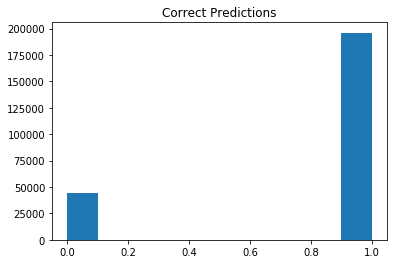

In [332]:
print('Accuracy :',round(np.mean(val_acc),2))

plt.hist(np.asarray(num_equals).flatten())
plt.title('Correct Predictions')

In [333]:
print(num_equal.shape)

(100, 1)


(array([ 21126.,      0.,      0.,      0.,      0., 196112.,      0.,
             0.,      0.,  22762.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

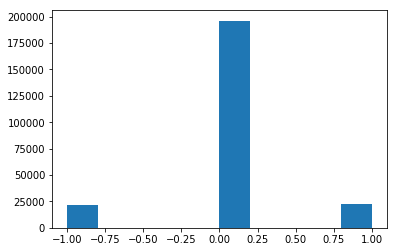

In [334]:
plt.hist(np.round(y_pred).flatten()-np.asarray(y_true).flatten())

(array([117928.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 122072.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

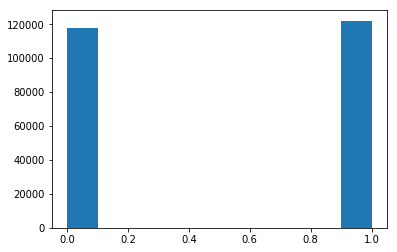

In [335]:
plt.hist(np.round(y_pred).flatten())

In [330]:
print(len(np.asarray(y_true).flatten()))

240000
